# Описание

Этот проект посвящен одному аспекту анализа футбольных трансферов в целом и принципа формирования трансферной стоимости игрока в частности. Я рассматриваю данные по трансферам нападающих за 6 сезонов (с сезона 2014-2015 до сезона 2019-2020 включительно) в топ-5 европейских лигах: чемпионатах Испании (Laliga), Англии (Premier League), Италии (Serie A), Франции (League 1) и Германии (Bundesliga). Данные об этих трансферах взяты из открытого github-проекта (https://github.com/emordonez/transfermarkt-transfers/tree/master/data). Основная гипотеза заключается в том, что так как основная функция нападающих в футболе - забивать голы, то при поиске игрока менеджмент клубов ориентируется именно на этот показатель, игнорируя тот факт, что большое количество голов у форварда в один конкретный сезон может быть следствием везения и аномально высокой реализации моментов ("оверперфоманса"), а не его истинного уровня игры. В результате клубы платят за таких игроков больше их реальной стоимости, но в следующем сезоне аномальная реализация заканчивается и игрок начинает забивать столько же, сколько и должен исходя из количества и качества его голевых моментов, не оправдывая ожидания клуба. Чтобы проверить эти гипотезы, я беру в качестве показателя оверперфоманса разницу между фактическими и ожидаемыми голами за сезон. Ожидаемые голы (xG) - это довольно широко применяемая в футболе метрика, которая присваивает каждому удару вероятность стать голом (исходя из того, сколько ударов, совершённых из аналогичной ситуации в других матчах, становились голами) и выдаёт показатель, который соотвествует количеству голов, которое игрок должен был бы забить, если исключить фактор везения или невезения. Данные по этим показателям взяты из открытого датасета на kaggle (https://www.kaggle.com/datasets/jashsheth5/indepth-soccer-statistics-xg-xa-and-more). Анализируя взаимосвязь между оверперфомансом игрока в конкретном сезоне и переплатой за него после этого сезона (то есть ситуацией, когда стоимость перехода была выше рыночной стоимости игрока по оценке портала Transfermarkt), я проверяю, насколько мои гипотезы подтверждаются на данных.

# Основная часть

Загружаем необходимые пакеты:

In [1]:
import csv
import sqlite3
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import re

Функция load_xG считывает данные из файла со статистическими показателями всех игроков топ-5 европейских лиг за отдельно взятый сезон. Так как в данном исследовании рассматриваются только нападающие, то эта функция заодно фильтрует игроков по позиции, отсеивая защитников, полузащитников и вратарей. В результате работы функции возвращается список кортежей, в каждом из которых содержится информация об одном нападающем

In [2]:
def load_xG(season):
    xG_goals = []
    with open(f'{season}.csv', mode ='r') as csvfile:
        csvFile = csv.reader(csvfile)
        for lines in csvFile:
            if ('F' in lines[15] or 'S' in lines[15]) and 'D' not in lines[15]:
                xG_goals.append(lines)
        return xG_goals

Создаём базу данных в sql, в которую будут записываться все имеющиеся у нас статистические данные о выступлениях нападающих за сезон. В этой базе содержатся следующие колонки:


1.   id - уникальный номер, идентифицирующий конкретный сезон конкретного игрока
2.   player_name - имя игрока
3. teams_played_for - команды, за которые выступал игрок в данном сезоне
4. league text - лига, в которой выступал игрок в данном сезоне
5. games - количество матчей, сыгранных нападающим в сезоне
6. minutes_played - суммарное количество минут, сыгранных игроком за сезон
7. goals - число голов, забитых игроком за сезон
8. npg - число голов без учёта пенальти, забитых игроком за сезон
9. assists - число голевых передач, отданных игроком за сезон
10. xG - ожидаемые голы игрока за сезон
11. xA - ожидаемые голевые передачи игрока за сезон
12. npxG - ожидаемые голы без учёта пенальти игрока за сезон
13. xG90 - ожидаемые голы в среднем за 90 минут игрока за сезон
14. xA90 - ожидаемые голевые передачи в среднем за 90 минут игрока за сезон
15. npxG90 - ожидаемые голы без учёта пенальти в среднем за 90 минут игрока за сезон
16. position - позиция, на которой выступает игрок
17. shots - число ударов игрока за сезон
18. key_passes - число передач, приводивших к голевым моментам, у игрока за сезон
19. yellow_cards - число жёлтых карточек у игрока за сезон
20. red_cards - число красных карточек у игрока за сезон
21. xGBuildup - ожидаемое количество голов, ставших результатом атакующих действий игрока (кроме ударов и ключевых передач) за сезон
22. xGChain - ожидаемое количество голов, ставших результатом всех атакующих действий игрока за сезон
23. season - сезон, к которому относятся данные



In [3]:
conn = sqlite3.connect("xg_transf_proj.sqlite")
cur = conn.cursor()

cur.execute("""
CREATE TABLE xg_goals (
    id integer PRIMARY KEY,
    player_name text,
    teams_played_for text,
    league text,
    games int,
    minutes_played int,
    goals int,
    npg int,
    assists int,
    xG float,
    xA float,
    npxG float,
    xG90 float,
    xA90 float,
    npxG90 float,
    position text,
    shots int,
    key_passes int,
    yellow_cards int,
    red_cards int,
    xGBuildup float,
    xGChain float,
    season text
)
""")

В sql-базу xg_goals записываются данные по всем 6 сезонам (с сезона 2014-2015 до сезона 2019-2020). Перед этим все данные приводятся к необходимому классу и к каждой записи добавляется сезон, к которому она относится

In [4]:
id = 0
for year in range(2014, 2020):
    xgdata = []
    for i in range(len(load_xG(f'{str(year)}-{str(year + 1)}'))):
        line = load_xG(f'{str(year)}-{str(year + 1)}')[i]
        line.append(f'{str(year)}-{str(year + 1)}')
        for number in [0, 4, 5, 6, 7, 8, 16, 17, 18, 19]:
            line[number] = int(line[number])
        for number in [9, 10, 11, 12, 13, 14, 20, 21]:
            line[number] = float(line[number])
        line[0] = id
        xgdata.append(tuple(line))
        id += 1

    cur.executemany("INSERT INTO xg_goals VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", xgdata)

In [5]:
#cur.execute("SELECT * FROM xg_goals")
#for student in cur.fetchall():
#    print(student)

Функция load_transfers принимает на вход год летнего трансферного окна, собирает данные из файлов с данными о трансферах каждой из лиг в этот год и возвращает список кортежей, каждый из которых - это информация об одном трансфере. Кроме того, она фильтрует игроков по позиции, оставляя только нападающих, и исключает трансферы с неизвестной суммой перехода или рыночной стоимостью игрока (так как мы рассматриваем ситуации, когда команды переплачивали за игроков, то отсутсвие этих данных делает такой анализ невозможным)

In [6]:
def load_transfers(season):
    transfers = []
    for league in ['1-bundesliga', 'laliga', 'ligue-1', 'premier-league', 'serie-a']:
        with open(f'{league}{season}.csv', mode ='r') as csvfile:
            csvFile = csv.reader(csvfile)
            for lines in csvFile:
                if lines[5] in ['CF', 'LW', 'RW', 'AM', 'SS', 'LM', 'RM'] and lines[11] == 'summer' and lines[14] == 'False':
                    if lines[9] != '0' and lines[9] != '' and lines[6] != '':
                        transfers.append(lines)
    return transfers

Создаём базу данных в sql, в которую будут записываться все имеющиеся у нас данные о трансферах нападающих за 6 сезонов. В этой базе содержатся следующие колонки:
1. transfer_id - уникальный номер, идентифицирующий конкретный трансфер
2. club - клуб, куда переходит/откуда уходит игрок (в зависимости от значения в колонке movement)
3. name - имя игрока
4. age - возраст игрока
5. nationality - национальность игрока
6. position2 - позиция, на которой выступает игрок
7. short_position - сокращенное обозначение позиции
8. market_value - рыночная стоимость игрока (по данным портала Transfermarkt)
9. dealing_club - клуб, с которым совершается сделка
10. dealing_country - страна, с клубом из которой совершается сделка
11. fee - стоимость трансфера
12. movement - принимает значение in (если игрок приходит в клуб) или out (если уходит из клуба)
13. window - трансферное окно, в которое произошёл переход (зимнее или летнее)
14. transfer_league - лига, в которой выступает клуб, указанный в колонке club
15. transfer_year - год, когда произошёл трансфера
16. is_loan - является ли переход арендой или полноценным трансфером
17. loan_status - дополнительная информация об аренде (пустая ячейка, если речь о полноценном трансфере)

In [7]:
cur.execute("""
CREATE TABLE transfers (
    transfer_id integer PRIMARY KEY,
    club text,
    name text,
    age int,
    nationality text,
    position2 text,
    short_position text,
    market_value float,
    dealing_club text,
    dealing_country text,
    fee float,
    movement text,
    window text,
    transfer_league text,
    transfer_year text,
    is_loan text,
    loan_status text
)
""")

В sql-базу transfers записываются данные по всем 6 трансферным окнам (2015-2020). Перед этим все данные приводятся к необходимому классу, а данные в колонке transfer_year переводятся в формат "даты сезона, предшествующего рассматриваемому трансферному окну" (например, 2015 -> 2014-2015) для унификации с базой данных xG_goals

In [8]:
id = 0
for year in range(2015, 2021):
    transfers_data = []
    for i in range(len(load_transfers(str(year)))):
        line = load_transfers(str(year))[i]
        line.insert(0, id)
        line[3] = int(line[3])
        for number in [7, 10]:
            line[number] = float(line[number])
        line[-3] = f'{str(int(line[-3]) - 1)}-{line[-3]}'
        transfers_data.append(tuple(line))
        id += 1

    cur.executemany("INSERT INTO transfers VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", transfers_data)

In [9]:
#cur.execute("SELECT * FROM transfers")
#for student in cur.fetchall():
#    print(student)

In [10]:
#cur.execute("SELECT * FROM transfers LEFT JOIN xg_goals ON transfers.name = xg_goals.player_name AND transfers.transfer_year = xg_goals.season")
#for transfer in cur.fetchall():
#   print(transfer)

В pandas создаётся датафрейм transfers, в который будут записаны все данные, полученный путём совмещения двух sql-баз. Колонки в этом датафрейме идентичны колонкам баз sql

In [11]:
transfers = pd.DataFrame(columns=['transfer_id',
    'club',
    'name',
    'age',
    'nationality',
    'position2',
    'short_position',
    'market_value',
    'dealing_club',
    'dealing_country',
    'fee',
    'movement',
    'window',
    'transfer_league',
    'transfer_year',
    'is_loan',
    'loan_status',
    'id',
    'player_name',
    'teams_played_for',
    'league',
    'games',
    'minutes_played',
    'goals',
    'npg',
    'assists',
    'xG',
    'xA',
    'npxG',
    'xG90',
    'xA90',
    'npxG90',
    'position',
    'shots',
    'key_passes',
    'yellow_cards',
    'red_cards',
    'xGBuildup',
    'xGChain',
    'season'])

2 полученные базы данных соединяются с помощью SQL. Т. к. статистические показатели игрока интересуют нас, только если он перешёл в другой клуб по итогам сезона, то логично взять за основу базу данных transfers, с помощью LEFT JOIN дополнив её данными из базы данных xG_goals. После этого полученная информация записывается в датафрейм transfers, причём все трансферы игроков, по которым нет данных за предыдущий сезон, исключаются

In [12]:
cur.execute("SELECT * FROM transfers LEFT JOIN xg_goals ON transfers.name = xg_goals.player_name AND transfers.transfer_year = xg_goals.season")
for transfer in cur.fetchall():
    if None not in list(transfer):
        transfers.loc[len(transfers.index)] = list(transfer)
transfers

,transfer_id,club,name,age,nationality,position2,short_position,market_value,dealing_club,dealing_country,...,xA90,npxG90,position,shots,key_passes,yellow_cards,red_cards,xGBuildup,xGChain,season
0,0,1. FC Köln,Anthony Modeste,27,France,Centre-Forward,CF,5500000.0,TSG Hoffenheim,Germany,...,0.023584,0.563723,F S,58,10,2,0,1.175187,8.586868,2014-2015
1,1,1. FC Köln,Leonardo Bittencourt,21,Germany,Attacking Midfield,AM,4000000.0,Hannover 96,Germany,...,0.112463,0.156897,M S,30,16,5,1,1.461155,5.028438,2014-2015
2,2,1. FC Köln,Anthony Ujah,24,Nigeria,Centre-Forward,CF,3000000.0,Werder Bremen,Germany,...,0.155602,0.303503,F S,59,33,2,0,3.046834,12.668221,2014-2015
3,3,1. FC Köln,Daniel Halfar,27,Germany,Attacking Midfield,AM,1700000.0,1.FC K'lautern,Germany,...,0.086850,0.073792,M S,30,24,1,0,2.636570,4.276089,2014-2015
4,5,1. FC Köln,Thomas Bröker,30,Germany,Centre-Forward,CF,500000.0,MSV Duisburg,Germany,...,0.000000,0.015356,S,1,0,1,0,0.048764,0.062073,2014-2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,2803,SSC Napoli,Simone Verdi,28,Italy,Attacking Midfield,AM,13000000.0,Torino,Italy,...,0.172725,0.148099,F M S,53,47,4,0,4.793737,7.947608,2019-2020
1405,2804,SSC Napoli,Roberto Inglese,28,Italy,Centre-Forward,CF,12000000.0,Parma,Italy,...,0.031491,0.490831,F S,24,6,1,0,0.785180,4.436611,2019-2020
1406,2807,SSC Napoli,José Callejón,33,Spain,Right Winger,RW,7500000.0,Fiorentina,Italy,...,0.257026,0.223970,F M S,42,63,2,0,7.379302,14.938511,2019-2020
1407,2811,Torino FC,Simone Verdi,28,Italy,Attacking Midfield,AM,13000000.0,SSC Napoli,Italy,...,0.172725,0.148099,F M S,53,47,4,0,4.793737,7.947608,2019-2020


Некоторые игроки в течение сезона выступали за 2 клуба, поэтому к одной записи об их трансфере в базе данных transfers было создано 2 записи в итоговом датафрейме (по одной на каждый клуб). Эти записи затруднят группировку трансферов по лигам, кроме того, для анализа этих случаев потребуются дополнительные соображения (например, если игрок забивал больше ожидаемого в одну половину сезона и меньше - во вторую, то это может оказать неожиданное влияние на итоговую цену трансфера). Чтобы избежать этих проблем, мы удаляем данные записи, находя их по совпадающим transfer_id

In [13]:
xGtransfers = pd.DataFrame(columns=['transfer_id',
    'club',
    'name',
    'age',
    'nationality',
    'position2',
    'short_position',
    'market_value',
    'dealing_club',
    'dealing_country',
    'fee',
    'movement',
    'window',
    'transfer_league',
    'transfer_year',
    'is_loan',
    'loan_status',
    'id',
    'player_name',
    'teams_played_for',
    'league',
    'games',
    'minutes_played',
    'goals',
    'npg',
    'assists',
    'xG',
    'xA',
    'npxG',
    'xG90',
    'xA90',
    'npxG90',
    'position',
    'shots',
    'key_passes',
    'yellow_cards',
    'red_cards',
    'xGBuildup',
    'xGChain',
    'season'])
cur.execute("SELECT * FROM transfers LEFT JOIN xg_goals ON transfers.name = xg_goals.player_name AND transfers.transfer_year = xg_goals.season")
for transfer in cur.fetchall():
    if None not in list(transfer):
        if transfers['transfer_id'].value_counts()[list(transfer)[0]] == 1:
            xGtransfers.loc[len(xGtransfers.index)] = list(transfer)
xGtransfers

,transfer_id,club,name,age,nationality,position2,short_position,market_value,dealing_club,dealing_country,...,xA90,npxG90,position,shots,key_passes,yellow_cards,red_cards,xGBuildup,xGChain,season
0,0,1. FC Köln,Anthony Modeste,27,France,Centre-Forward,CF,5500000.0,TSG Hoffenheim,Germany,...,0.023584,0.563723,F S,58,10,2,0,1.175187,8.586868,2014-2015
1,1,1. FC Köln,Leonardo Bittencourt,21,Germany,Attacking Midfield,AM,4000000.0,Hannover 96,Germany,...,0.112463,0.156897,M S,30,16,5,1,1.461155,5.028438,2014-2015
2,2,1. FC Köln,Anthony Ujah,24,Nigeria,Centre-Forward,CF,3000000.0,Werder Bremen,Germany,...,0.155602,0.303503,F S,59,33,2,0,3.046834,12.668221,2014-2015
3,3,1. FC Köln,Daniel Halfar,27,Germany,Attacking Midfield,AM,1700000.0,1.FC K'lautern,Germany,...,0.086850,0.073792,M S,30,24,1,0,2.636570,4.276089,2014-2015
4,5,1. FC Köln,Thomas Bröker,30,Germany,Centre-Forward,CF,500000.0,MSV Duisburg,Germany,...,0.000000,0.015356,S,1,0,1,0,0.048764,0.062073,2014-2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,2803,SSC Napoli,Simone Verdi,28,Italy,Attacking Midfield,AM,13000000.0,Torino,Italy,...,0.172725,0.148099,F M S,53,47,4,0,4.793737,7.947608,2019-2020
1269,2804,SSC Napoli,Roberto Inglese,28,Italy,Centre-Forward,CF,12000000.0,Parma,Italy,...,0.031491,0.490831,F S,24,6,1,0,0.785180,4.436611,2019-2020
1270,2807,SSC Napoli,José Callejón,33,Spain,Right Winger,RW,7500000.0,Fiorentina,Italy,...,0.257026,0.223970,F M S,42,63,2,0,7.379302,14.938511,2019-2020
1271,2811,Torino FC,Simone Verdi,28,Italy,Attacking Midfield,AM,13000000.0,SSC Napoli,Italy,...,0.172725,0.148099,F M S,53,47,4,0,4.793737,7.947608,2019-2020


Исключаем игроков, перешедших в другой клуб после истечения контракта с предыдущим (стоимость таких переходов всегда равна 0, поэтому они нерелевантны для нашего анализа), а также тех, кто провёл за сезон меньше 2 полных матчей (очевидно, что в таких случаях при покупке игрока менеджмент клубов ориентируется не на его статистику в прошлом сезоне, когда он практически не играл, а на другие факторы. Зачастую в эту категорию попадают игроки, которые пропустили почти весь сезон из-за тяжёлой травмы)

In [14]:
xG_transfers = xGtransfers[(xGtransfers['fee'] != 0) & (xGtransfers['minutes_played'] >= 180)]

In [15]:
xG_transfers

,transfer_id,club,name,age,nationality,position2,short_position,market_value,dealing_club,dealing_country,...,xA90,npxG90,position,shots,key_passes,yellow_cards,red_cards,xGBuildup,xGChain,season
0,0,1. FC Köln,Anthony Modeste,27,France,Centre-Forward,CF,5500000.0,TSG Hoffenheim,Germany,...,0.023584,0.563723,F S,58,10,2,0,1.175187,8.586868,2014-2015
1,1,1. FC Köln,Leonardo Bittencourt,21,Germany,Attacking Midfield,AM,4000000.0,Hannover 96,Germany,...,0.112463,0.156897,M S,30,16,5,1,1.461155,5.028438,2014-2015
2,2,1. FC Köln,Anthony Ujah,24,Nigeria,Centre-Forward,CF,3000000.0,Werder Bremen,Germany,...,0.155602,0.303503,F S,59,33,2,0,3.046834,12.668221,2014-2015
3,3,1. FC Köln,Daniel Halfar,27,Germany,Attacking Midfield,AM,1700000.0,1.FC K'lautern,Germany,...,0.086850,0.073792,M S,30,24,1,0,2.636570,4.276089,2014-2015
7,11,1.FSV Mainz 05,Shinji Okazaki,29,Japan,Centre-Forward,CF,8000000.0,Leicester,England,...,0.105710,0.317525,F S,59,26,4,0,2.356664,12.567015,2014-2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,2801,SSC Napoli,Victor Osimhen,21,Nigeria,Centre-Forward,CF,40000000.0,LOSC Lille,France,...,0.120361,0.530967,F S,86,21,4,0,0.241949,14.645045,2019-2020
1268,2803,SSC Napoli,Simone Verdi,28,Italy,Attacking Midfield,AM,13000000.0,Torino,Italy,...,0.172725,0.148099,F M S,53,47,4,0,4.793737,7.947608,2019-2020
1269,2804,SSC Napoli,Roberto Inglese,28,Italy,Centre-Forward,CF,12000000.0,Parma,Italy,...,0.031491,0.490831,F S,24,6,1,0,0.785180,4.436611,2019-2020
1271,2811,Torino FC,Simone Verdi,28,Italy,Attacking Midfield,AM,13000000.0,SSC Napoli,Italy,...,0.172725,0.148099,F M S,53,47,4,0,4.793737,7.947608,2019-2020


Удаляем ненужные и дублирующиеся колонки:

In [16]:
del xG_transfers['position']
del xG_transfers['transfer_year']
del xG_transfers['yellow_cards']
del xG_transfers['red_cards']
del xG_transfers['league']
del xG_transfers['teams_played_for']
del xG_transfers['player_name']
del xG_transfers['is_loan']
del xG_transfers['loan_status']
del xG_transfers['window']

В результате мы получили датафрейм xG_transfers, с которым и будем работать в дальнейшем

In [17]:
xG_transfers.isnull().sum()

transfer_id        0
club               0
name               0
age                0
nationality        0
position2          0
short_position     0
market_value       0
dealing_club       0
dealing_country    0
fee                0
movement           0
transfer_league    0
id                 0
games              0
minutes_played     0
goals              0
npg                0
assists            0
xG                 0
xA                 0
npxG               0
xG90               0
xA90               0
npxG90             0
shots              0
key_passes         0
xGBuildup          0
xGChain            0
season             0
dtype: int64

Как видно, после обработки в датасете не оказалось пропусков.
Теперь посчитаем показатели "оверперфоманса" нападающих (ситуаций, когда они забивают больше ожидаемого) и переплат за них при трансферах

In [18]:
xG_transfers['xGdiff'] = xG_transfers['goals'] - xG_transfers['xG']
xG_transfers['npxGdiff90'] = xG_transfers['npg'] * 90 / xG_transfers['minutes_played'] - xG_transfers['npxG90']
xG_transfers['npxGdiff'] = xG_transfers['npg'] - xG_transfers['npxG']
xG_transfers['xGdiff90'] = xG_transfers['goals'] * 90 / xG_transfers['minutes_played'] - xG_transfers['xG90']
xG_transfers['xAdiff'] = xG_transfers['assists'] - xG_transfers['xA']
xG_transfers['xAdiff90'] = xG_transfers['assists'] * 90 / xG_transfers['minutes_played'] - xG_transfers['xA90']
xG_transfers['xGAdiff'] = xG_transfers['goals'] - xG_transfers['xG'] + xG_transfers['assists'] - xG_transfers['xA']
xG_transfers['xGAdiff90'] = xG_transfers['goals'] * 90 / xG_transfers['minutes_played'] - xG_transfers['xG90'] + xG_transfers['assists'] * 90 / xG_transfers['minutes_played'] - xG_transfers['xA90']
xG_transfers['overpay'] = xG_transfers['fee'] - xG_transfers['market_value']

<ipython-input-18-59a8b0afd8b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xG_transfers['xGdiff'] = xG_transfers['goals'] - xG_transfers['xG']
<ipython-input-18-59a8b0afd8b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xG_transfers['npxGdiff90'] = xG_transfers['npg'] * 90 / xG_transfers['minutes_played'] - xG_transfers['npxG90']
<ipython-input-18-59a8b0afd8b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Начнём проверять нашу гипотезу о взаимосвязи между оверперфомансом и переплатой за игрока. Для начала посмотрим на коэффициент корреляции между этими показателями:

In [19]:
%matplotlib inline
xG_transfers[['overpay', 'xGdiff', 'xGdiff90', 'npxGdiff', 'npxGdiff90', 'xAdiff', 'xAdiff90', 'xGAdiff', 'xGAdiff90']].corr().style.background_gradient(cmap='coolwarm')

,overpay,xGdiff,xGdiff90,npxGdiff,npxGdiff90,xAdiff,xAdiff90,xGAdiff,xGAdiff90
overpay,1.000000,-0.023789,-0.015420,-0.021554,-0.013301,0.022573,0.004497,-0.006051,-0.009660
xGdiff,-0.023789,1.000000,0.782963,0.985535,0.770976,-0.024684,0.001331,0.804039,0.617319
xGdiff90,-0.015420,0.782963,1.000000,0.774507,0.990050,0.002864,0.086238,0.642730,0.835116
npxGdiff,-0.021554,0.985535,0.774507,1.000000,0.782481,-0.035297,-0.002275,0.785884,0.608669
npxGdiff90,-0.013301,0.770976,0.990050,0.782481,1.000000,-0.000751,0.087167,0.630767,0.827793
xAdiff,0.022573,-0.024684,0.002864,-0.035297,-0.000751,1.000000,0.812941,0.574549,0.451105
xAdiff90,0.004497,0.001331,0.086238,-0.002275,0.087167,0.812941,1.000000,0.484593,0.620043
xGAdiff,-0.006051,0.804039,0.642730,0.785884,0.630767,0.574549,0.484593,1.000000,0.773710
xGAdiff90,-0.009660,0.617319,0.835116,0.608669,0.827793,0.451105,0.620043,0.773710,1.000000


Как видно, пока никакой корреляции не прослеживается. Более того, коэффициент корреляции между переплатой и оверперфомансом относительно ожидаемых голов даже отрицательный!
Однако гипотеза заключалась в том, что именно заметное превышение фактических голов над ожидаемыми приводит к переплате за игрока. Поэтому логично рассматривать только те случаи, когда у игрока был заметный оверперфоманс относительно xG:

In [20]:
#xG_transfers[xG_transfers['xGdiff'] > 1][['overpay', 'xGdiff', 'xGdiff90', 'npxGdiff', 'npxGdiff90', 'xAdiff', 'xAdiff90', 'xGAdiff', 'xGAdiff90']].corr().style.background_gradient(cmap='coolwarm')
xG_transfers[xG_transfers['xGdiff90'] > 0.08][['overpay', 'xGdiff', 'xGdiff90', 'npxGdiff', 'npxGdiff90', 'xAdiff', 'xAdiff90', 'xGAdiff', 'xGAdiff90', 'goals']].corr().style.background_gradient(cmap='coolwarm')

,overpay,xGdiff,xGdiff90,npxGdiff,npxGdiff90,xAdiff,xAdiff90,xGAdiff,xGAdiff90,goals
overpay,1.000000,0.196013,0.081458,0.217812,0.090878,-0.135256,-0.045436,0.055956,0.034807,0.129403
xGdiff,0.196013,1.000000,0.177767,0.978187,0.158393,-0.183472,-0.148351,0.668647,0.048652,0.784885
xGdiff90,0.081458,0.177767,1.000000,0.176154,0.993462,-0.047918,0.181942,0.107288,0.837904,-0.040340
npxGdiff,0.217812,0.978187,0.176154,1.000000,0.179561,-0.175482,-0.139286,0.657078,0.052495,0.733694
npxGdiff90,0.090878,0.158393,0.993462,0.179561,1.000000,-0.039481,0.191159,0.098027,0.838202,-0.069419
xAdiff,-0.135256,-0.183472,-0.047918,-0.175482,-0.039481,1.000000,0.807642,0.608280,0.412996,-0.114966
xAdiff90,-0.045436,-0.148351,0.181942,-0.139286,0.191159,0.807642,1.000000,0.491134,0.689157,-0.098030
xGAdiff,0.055956,0.668647,0.107288,0.657078,0.098027,0.608280,0.491134,1.000000,0.351682,0.546776
xGAdiff90,0.034807,0.048652,0.837904,0.052495,0.838202,0.412996,0.689157,0.351682,1.000000,-0.084142
goals,0.129403,0.784885,-0.040340,0.733694,-0.069419,-0.114966,-0.098030,0.546776,-0.084142,1.000000


Уже лучше. Теперь коэффициент корреляции между переплатой и оверперфомансом находится в районе 0.2. Кроме того, видно, что оверперфоманс сильнее влияет на размер переплаты, чем количество голов (то есть клубы переплачивают не за тех, кто забил много голов, а за тех, кто забил больше ожидаемого). При этом заметим, что с показателем npxGdiff (превышение голов без учёта пенальти над ожидаемыми) корреляция выше, чем просто с xGdiff. Можно сделать первый вывод: клубы склонны рассматривать мастерство исполнения пенальти как отдельный навык, не связанный непосредственно с уровнем реализации моментов с игры, а при покупке игрока выше ценят именно последнее. Поэтому в дальнейшем будем фильтровать игроков именно по этому показателю.

In [21]:
xG_transfers[xG_transfers['npxGdiff90'] > 0.08][['overpay', 'xGdiff', 'xGdiff90', 'npxGdiff', 'npxGdiff90', 'xAdiff', 'xAdiff90', 'xGAdiff', 'xGAdiff90', 'goals']].corr().style.background_gradient(cmap='coolwarm')

,overpay,xGdiff,xGdiff90,npxGdiff,npxGdiff90,xAdiff,xAdiff90,xGAdiff,xGAdiff90,goals
overpay,1.000000,0.207157,0.082047,0.228123,0.091847,-0.111861,-0.021317,0.086291,0.048745,0.145192
xGdiff,0.207157,1.000000,0.165536,0.979070,0.141260,-0.184402,-0.159543,0.681357,0.034571,0.790205
xGdiff90,0.082047,0.165536,1.000000,0.157903,0.994022,-0.023500,0.196482,0.118021,0.843833,-0.043078
npxGdiff,0.228123,0.979070,0.157903,1.000000,0.155052,-0.165544,-0.146099,0.678266,0.036308,0.744544
npxGdiff90,0.091847,0.141260,0.994022,0.155052,1.000000,-0.010075,0.207612,0.108144,0.845522,-0.074253
xAdiff,-0.111861,-0.184402,-0.023500,-0.165544,-0.010075,1.000000,0.806528,0.593755,0.424089,-0.144557
xAdiff90,-0.021317,-0.159543,0.196482,-0.146099,0.207612,0.806528,1.000000,0.470024,0.691945,-0.120265
xGAdiff,0.086291,0.681357,0.118021,0.678266,0.108144,0.593755,0.470024,1.000000,0.344131,0.539275
xGAdiff90,0.048745,0.034571,0.843833,0.036308,0.845522,0.424089,0.691945,0.344131,1.000000,-0.097536
goals,0.145192,0.790205,-0.043078,0.744544,-0.074253,-0.144557,-0.120265,0.539275,-0.097536,1.000000


Тем не менее, пока корреляция всё равно кажется довольно низкой. Значит, есть какие-то другие факторы, которые необходимо учитывать. Можно предположить, что одним из них является возраст. Он существенно влияет на стоимость игрока: из двух нападающих сопоставимого уровня за более молодого обычно готовы заплатить больше, так как он сможет дольше приносить пользу команде. Кроме того, считается, что уровень игры и реализации моментов возрастных игроков хорошо известен, их трудно "переучить" и сменить им технику, в то время как молодые представляют собой "кота в мешке". Поэтому моя гипотеза заключается в том, что оверперфоманс возрастного игрока воспринимается менеджментом клубом как случайное везение и поэтому риск переоценить его существенно меньше. В случае же с молодым игроком есть шанс, что оверперфоманс является показателем особого стиля игры футболиста, который позволяет ему систематически забивать больше ожидаемого, поэтому менеджеры готовы взять на себя риск и переплатить за него. Проверим эту гипотезу на данных:

In [22]:
xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['age'] <= 23)][['overpay', 'xGdiff', 'xGdiff90', 'npxGdiff', 'npxGdiff90', 'xAdiff', 'xAdiff90', 'xGAdiff', 'xGAdiff90']].corr().style.background_gradient(cmap='coolwarm')

,overpay,xGdiff,xGdiff90,npxGdiff,npxGdiff90,xAdiff,xAdiff90,xGAdiff,xGAdiff90
overpay,1.000000,-0.115811,0.084393,-0.120680,0.085286,0.085104,0.164141,-0.029042,0.135665
xGdiff,-0.115811,1.000000,0.067088,0.983840,0.061296,-0.344625,-0.120839,0.587233,-0.003955
xGdiff90,0.084393,0.067088,1.000000,0.046896,0.997507,0.069772,0.380151,0.119491,0.911430
npxGdiff,-0.120680,0.983840,0.046896,1.000000,0.053482,-0.326384,-0.110844,0.588669,-0.014497
npxGdiff90,0.085286,0.061296,0.997507,0.053482,1.000000,0.077900,0.387581,0.121377,0.912885
xAdiff,0.085104,-0.344625,0.069772,-0.326384,0.077900,1.000000,0.764112,0.557459,0.391709
xAdiff90,0.164141,-0.120839,0.380151,-0.110844,0.387581,0.764112,1.000000,0.551979,0.727045
xGAdiff,-0.029042,0.587233,0.119491,0.588669,0.121377,0.557459,0.551979,1.000000,0.334249
xGAdiff90,0.135665,-0.003955,0.911430,-0.014497,0.912885,0.391709,0.727045,0.334249,1.000000


In [23]:
xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['age'] > 26)][['overpay', 'xGdiff', 'xGdiff90', 'npxGdiff', 'npxGdiff90', 'xAdiff', 'xAdiff90', 'xGAdiff', 'xGAdiff90']].corr().style.background_gradient(cmap='coolwarm')

,overpay,xGdiff,xGdiff90,npxGdiff,npxGdiff90,xAdiff,xAdiff90,xGAdiff,xGAdiff90
overpay,1.000000,0.356369,0.281251,0.412539,0.317442,-0.349024,-0.283064,0.001248,-0.064431
xGdiff,0.356369,1.000000,0.401458,0.975640,0.344590,-0.011624,0.035687,0.697260,0.301937
xGdiff90,0.281251,0.401458,1.000000,0.421352,0.974957,-0.115518,-0.211365,0.200455,0.483133
npxGdiff,0.412539,0.975640,0.421352,1.000000,0.411226,-0.032428,0.015703,0.665159,0.297414
npxGdiff90,0.317442,0.344590,0.974957,0.411226,1.000000,-0.135926,-0.231234,0.145699,0.448495
xAdiff,-0.349024,-0.011624,-0.115518,-0.032428,-0.135926,1.000000,0.925232,0.708665,0.751126
xAdiff90,-0.283064,0.035687,-0.211365,0.015703,-0.231234,0.925232,1.000000,0.688449,0.753648
xGAdiff,0.001248,0.697260,0.200455,0.665159,0.145699,0.708665,0.688449,1.000000,0.751502
xGAdiff90,-0.064431,0.301937,0.483133,0.297414,0.448495,0.751126,0.753648,0.751502,1.000000


In [24]:
xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['age'] > 31)][['overpay', 'xGdiff', 'xGdiff90', 'npxGdiff', 'npxGdiff90', 'xAdiff', 'xAdiff90', 'xGAdiff', 'xGAdiff90']].corr().style.background_gradient(cmap='coolwarm')

,overpay,xGdiff,xGdiff90,npxGdiff,npxGdiff90,xAdiff,xAdiff90,xGAdiff,xGAdiff90
overpay,1.000000,0.539689,0.505966,0.568648,0.554903,-0.942894,-0.946452,-0.351620,-0.595051
xGdiff,0.539689,1.000000,0.898600,0.993504,0.934334,-0.631843,-0.639924,0.550088,0.171591
xGdiff90,0.505966,0.898600,1.000000,0.869952,0.985322,-0.605651,-0.598238,0.453500,0.325356
npxGdiff,0.568648,0.993504,0.869952,1.000000,0.922731,-0.675721,-0.686982,0.494817,0.086515
npxGdiff90,0.554903,0.934334,0.985322,0.922731,1.000000,-0.668418,-0.672867,0.429856,0.222152
xAdiff,-0.942894,-0.631843,-0.605651,-0.675721,-0.668418,1.000000,0.993210,0.299719,0.547423
xAdiff90,-0.946452,-0.639924,-0.598238,-0.686982,-0.672867,0.993210,1.000000,0.282458,0.563080
xGAdiff,-0.351620,0.550088,0.453500,0.494817,0.429856,0.299719,0.282458,1.000000,0.801009
xGAdiff90,-0.595051,0.171591,0.325356,0.086515,0.222152,0.547423,0.563080,0.801009,1.000000


Как видно, результаты оказались прямо противоположными ожидаемым! Для молодых игроков (младше 24 лет) переплата никак не коррелирует с оверперфомансом, коэффициент корреляции даже меньше 0. В то же время если рассматривать игроков в расцвете сил и старше (с 27 лет), то прослеживается довольно чёткая связь между этими величинами и коэффициент корреляции превышает 0.4. Если идти дальше и увеличивать минимальный возраст, то корреляция будет заметна ещё сильнее: для "ветеранов" (старше 31 года) коэффициент и вовсе составит 0.57. С одной стороны, это означает, что в целом изначальная гипотеза верна и связь между оверперфомансом и переплатой за нападающего существует. С другой стороны, то, что эта зависимость абсолютно не работает для молодых игроков, кажется парадоксальным. Я могу предложить следующее объяснение: возраст игрока является одним из наиболее важных факторов при оценке его рыночной стоимости порталом Transfermarkt. Молодые игроки, которые провели буквально пару сезонов на высоком уровне, оцениваются гораздо выше, чем возрастные звёзды, которые подтверждали свой класс на протяжении много лет. Несомненно, покупая возрастного игрока, клуб не ожидает, что он внезапно станет выступать лучше, чем до этого, но при этом может быть уверен, что он и не упадёт ниже своего обычного уровня. Молодой же игрок после перехода может как раскрыться, так и провалиться, не справившись с новыми условиями и требованиями. Вероятно, даже оверперфоманс на дистанции одного сезона зачастую не может заставить менеджмент взять на себя такие риски, и цена, по которой клуб готов купить молодого игрока, на деле ниже рыночной. Поэтому отсутствие корреляции между оверперфомансом и переплатой за молодых игроков можно объяснить тем, что Transfermarkt систематически переоценивает их рыночную стоимость.

Теперь попробуем сгруппировать трансферы по лигам и посмотреть, какие закономерности будут заметны

In [25]:
league_grouper = xG_transfers[xG_transfers['npxGdiff90'] > 0.08].groupby(['transfer_league', 'movement'])
league_grouper[['npxGdiff', 'overpay']].agg(['mean', 'median'])

npxGdiff                 overpay           
                              mean    median          mean     median
transfer_league movement                                             
1 Bundesliga    in        2.921470  2.254367 -1.642500e+06  -800000.0
                out       2.483764  2.254285 -1.171053e+06  -500000.0
Laliga          in        2.736029  2.851993 -3.612500e+06 -1600000.0
                out       3.202206  2.716191  1.857143e+05        0.0
Ligue 1         in        2.265653  2.075143  9.210526e+04  -300000.0
                out       3.191427  2.918705  2.373684e+06  1000000.0
Premier League  in        3.859499  3.621169  7.162500e+06  5850000.0
                out       3.723034  3.593428  3.821875e+06  2750000.0
Serie A         in        2.689519  2.387604  2.817391e+06   900000.0
                out       2.864791  2.387604  1.684211e+06   900000.0

Видно, что сильнее всего переплачивают за забивших выше ожидаемого игроков в Английской Премьер-лиге, причём это относится к трансферам как на вход, так и на выход. В целом это согласуется с тем фактом, что именно английские клубы являются наиболее богатыми, и другие команды, продавая им игроков, знают это и потому требуют бОльшие суммы. При этом когда сами английские клубы продают игроков, они рассматривают только очень выгодные предложения, поскольку практически никогда не испытывают необходимости в срочных продажах для поддержания финансовой устойчивости. В чемпионатах Испании и Германии, напротив, за забивших больше ожидаемого игроков платят в среднем даже ниже их рыночной стоимости. Это может говорить о высокой квалификации трансферных отделов в этих лигах, которые обращают внимание на продвинутую статистику и не обманываются случайными отклонениями от ожидаемых голов в большую сторону.

Если посмотреть на соотношение оверперфоманса и переплат за игроков в чемпионате Англии, то видно, что, во-первых, почти всех игроков покупали дороже рыночной стоимости, во-вторых, за редким исключением, величина переплаты растёт с ростом оверперфоманса:

<Axes: xlabel='npxGdiff', ylabel='overpay'>

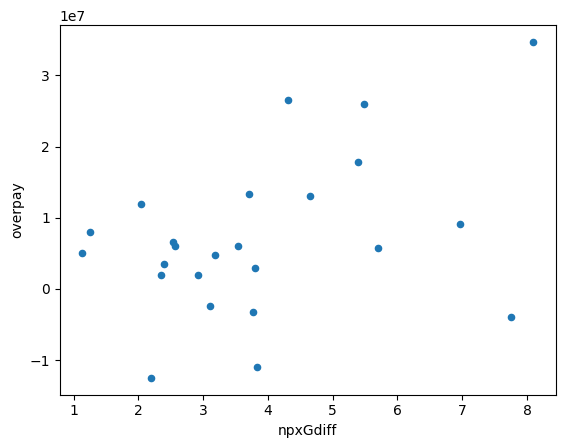

In [26]:
xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['transfer_league'] == 'Premier League') & (xG_transfers['movement'] == 'in')].plot.scatter(x='npxGdiff', y='overpay')

Теперь сгруппируем трансферы по странам и посмотрим, сколько в среднем переплачивали (или недоплачивали) за игроков из разных стран, забивавших больше ожидаемого. Визуализируем эту информацию по доступным странам на карте:

In [27]:
worldgeodata = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<ipython-input-27-79a812802e2e>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldgeodata = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


(-198.0, 198.00000000000006, -62.07502, 88.07542)

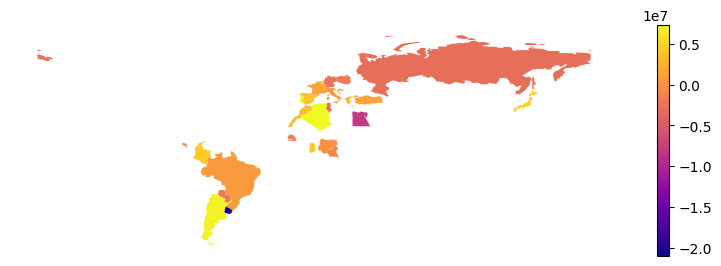

In [28]:
countries = list(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08)].nationality.unique())
overpays = list(map(lambda elem: xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['nationality'] == elem)]['overpay'].mean(), countries))
countries_series = pd.Series(data=countries)
overpays_series = pd.Series(data=overpays)
avg_overpays = pd.DataFrame({
    'name': countries_series,
    'overpay': overpays_series
})
geo_overpays = pd.merge(worldgeodata, avg_overpays, on='name', how='left')
canvas = geo_overpays.plot(column='overpay', linewidth=0.5, cmap='plasma', legend=True, figsize=[10, 3])
canvas.axis('off')

Видно, что переплачивали в основном за игроков из Европы и Южной Америки, которые традиционно считаются наиболее футбольными континентами

Построив граф с количеством переходов оверперформивших нападающих между разными лигами, мы можем заметить явное преимущество Английской Премьер-Лиги. Это согласуется с мнением, что английские клубы обычно покупают игроков, уже засветившихся в других топ-лигах, в то время как последние зачастую приобретают игроков из более слабых чемпионатов и развивают их

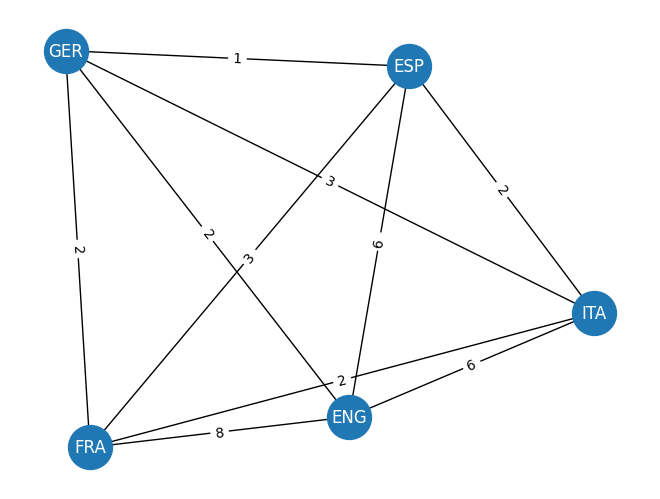

In [36]:
G = nx.Graph()
G.add_nodes_from(['GER', 'ESP', 'ENG', 'FRA', 'ITA'])
eng_ger = len(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['transfer_league'] == '1 Bundesliga') & (xG_transfers['dealing_country'] == 'England')])
eng_esp = len(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['transfer_league'] == 'Laliga') & (xG_transfers['dealing_country'] == 'England')])
eng_fra = len(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['transfer_league'] == 'Ligue 1') & (xG_transfers['dealing_country'] == 'England')])
eng_ita = len(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['transfer_league'] == 'Serie A') & (xG_transfers['dealing_country'] == 'England')])
esp_ger = len(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['transfer_league'] == '1 Bundesliga') & (xG_transfers['dealing_country'] == 'Spain')])
fra_esp = len(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['transfer_league'] == 'Laliga') & (xG_transfers['dealing_country'] == 'France')])
ita_esp = len(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['transfer_league'] == 'Laliga') & (xG_transfers['dealing_country'] == 'Italy')])
fra_ger = len(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['transfer_league'] == 'Ligue 1') & (xG_transfers['dealing_country'] == 'Germany')])
fra_ita = len(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['transfer_league'] == 'Serie A') & (xG_transfers['dealing_country'] == 'France')])
ger_ita = len(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['transfer_league'] == 'Serie A') & (xG_transfers['dealing_country'] == 'Germany')])
G.add_weighted_edges_from([('ESP', 'GER', esp_ger), ('ESP', 'FRA', fra_esp), ('ESP', 'ITA', ita_esp), ('FRA', 'GER', fra_ger)])
G.add_weighted_edges_from([('ENG', 'GER', eng_ger), ('ESP', 'ENG', eng_esp), ('ENG', 'FRA', eng_fra), ('ITA', 'ENG', eng_ita)])
G.add_weighted_edges_from([('FRA', 'ITA', fra_ita), ('GER', 'ITA', ger_ita)])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_color='white', node_size=1000)
edge_weight = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)
plt.show()

Теперь посмотрим динамику по сезонам переплат за нападающих, забивавших выше ожидаемого. В среднем, можно заметить тренд на снижение переплат с течением времени, который может быть обусловлен прогрессом в системе скаутинга игроков (клубы стали чаще использовать продвинутую статистику и понимать, что большое количество голов может быть результатом везения, а не уровня игрока).

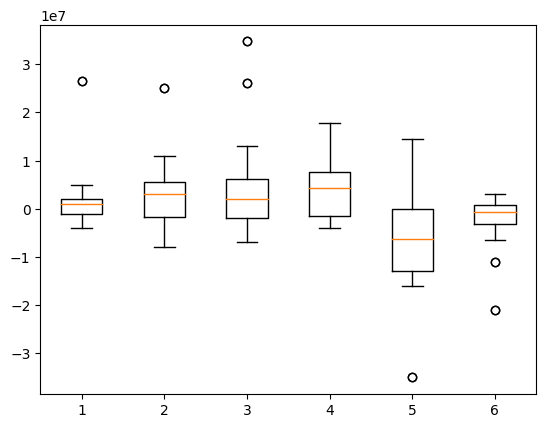

In [37]:
overpay_by_season = []
for year in range(2014, 2020):
    overpay_by_season.append(xG_transfers[(xG_transfers['npxGdiff90'] > 0.08) & (xG_transfers['season'] == f'{str(year)}-{str(year + 1)}')]['overpay'].tolist())
plt.boxplot(overpay_by_season)
plt.show()

Ещё одна важная гипотеза заключается в том, что оверперфоманс носит по большей части случайный характер, то есть игроки, которые в один конкретный сезон забили больше ожидаемого, в следующем вернутся к норме. Чтобы проверить эту гипотезу, посмотрим, насколько изменился показатель оверперфоманса у игроков, которые забили больше ожидаемого и за которых поэтому переплатили клубы, в следующем сезоне:

In [38]:
future_season = pd.read_sql(
    "SELECT * FROM xg_goals",
    conn,
)

In [39]:
current_seas = future_season['season'].tolist()
next_seas = {'2014-2015': '2013-2014', '2015-2016': '2014-2015', '2016-2017': '2015-2016', '2017-2018': '2016-2017', '2018-2019': '2017-2018', '2019-2020': '2018-2019'}
prev_seas = list(map(lambda season: next_seas[season], current_seas))
del future_season['season']
futureseason = future_season.assign(season=prev_seas)

In [40]:
futureseason.rename(columns={'player_name': 'name'}, inplace=True)


In [41]:
season_comparison = pd.merge(xG_transfers, futureseason, on=['name', 'season'], how='left')
season_comparison.dropna()

,transfer_id,club,name,age,nationality,position2,short_position,market_value,dealing_club,dealing_country,...,xG90_y,xA90_y,npxG90_y,position,shots_y,key_passes_y,yellow_cards,red_cards,xGBuildup_y,xGChain_y
0,0,1. FC Köln,Anthony Modeste,27,France,Centre-Forward,CF,5500000.0,TSG Hoffenheim,Germany,...,0.549112,0.085723,0.454324,F S,110.0,19.0,4.0,0.0,1.796016,17.817345
1,1,1. FC Köln,Leonardo Bittencourt,21,Germany,Attacking Midfield,AM,4000000.0,Hannover 96,Germany,...,0.144569,0.181244,0.144569,M S,37.0,38.0,2.0,1.0,5.209982,11.674550
2,2,1. FC Köln,Anthony Ujah,24,Nigeria,Centre-Forward,CF,3000000.0,Werder Bremen,Germany,...,0.480779,0.111857,0.451471,F S,68.0,27.0,2.0,0.0,2.899740,13.976040
4,11,1.FSV Mainz 05,Shinji Okazaki,29,Japan,Centre-Forward,CF,8000000.0,Leicester,England,...,0.368025,0.048504,0.368025,F S,46.0,20.0,1.0,0.0,3.896108,11.455141
5,15,Bayer 04 Leverkusen,Admir Mehmedi,24,Switzerland,Second Striker,SS,6000000.0,SC Freiburg,Germany,...,0.158785,0.211998,0.158785,F M S,28.0,33.0,2.0,0.0,2.215366,5.952282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,2417,UC Sampdoria,Jakub Jankto,23,Czech Republic,Left Midfield,LM,12000000.0,Udinese Calcio,Italy,...,0.094923,0.173716,0.094923,M S,42.0,44.0,8.0,0.0,4.405499,9.040859
819,2429,US Sassuolo,Francesco Caputo,31,Italy,Centre-Forward,CF,4000000.0,FC Empoli,Italy,...,0.438216,0.168888,0.391607,F S,73.0,53.0,3.0,0.0,4.791131,20.526268
820,2431,US Sassuolo,Matteo Politano,25,Italy,Right Winger,RW,30000000.0,Inter,Italy,...,0.238967,0.234032,0.238967,F M S,34.0,27.0,1.0,0.0,4.587148,7.490440
821,2438,Udinese Calcio,Jakub Jankto,23,Czech Republic,Left Midfield,LM,12000000.0,Sampdoria,Italy,...,0.094923,0.173716,0.094923,M S,42.0,44.0,8.0,0.0,4.405499,9.040859


In [42]:
season_comparison['xGdiff2'] = season_comparison['goals_y'] - season_comparison['xG_y']
season_comparison['npxGdiff902'] = season_comparison['npg_y'] * 90 / season_comparison['minutes_played_y'] - season_comparison['npxG90_y']
season_comparison['npxGdiff2'] = season_comparison['npg_y'] - season_comparison['npxG_y']
season_comparison['xGdiff902'] = season_comparison['goals_y'] * 90 /season_comparison['minutes_played_y'] - season_comparison['xG90_y']

In [43]:
season_comparison['2xGdiff2'] = season_comparison['xGdiff2'] - season_comparison['xGdiff']
season_comparison['2npxGdiff902'] = season_comparison['npxGdiff902'] - season_comparison['npxGdiff90']
season_comparison['2npxGdiff2'] = season_comparison['npxGdiff2'] - season_comparison['npxGdiff']
season_comparison['2xGdiff902'] = season_comparison['xGdiff902'] - season_comparison['xGdiff90']

In [44]:
season_comparison[(season_comparison['overpay'] > 0) & (season_comparison['npxGdiff90'] > 0.08)][['2xGdiff2', '2xGdiff902', '2npxGdiff2', '2npxGdiff902']]

,2xGdiff2,2xGdiff902,2npxGdiff2,2npxGdiff902
6,-2.358967,-0.272758,-2.358967,-0.272758
7,-2.358967,-0.272758,-2.358967,-0.272758
27,NaN,NaN,NaN,NaN
70,-3.991267,-0.138445,-4.734544,-0.160567
98,-3.294726,-0.175801,-3.095201,-0.167587
...,...,...,...,...
838,NaN,NaN,NaN,NaN
862,NaN,NaN,NaN,NaN
893,NaN,NaN,NaN,NaN
905,NaN,NaN,NaN,NaN


In [45]:
season_comparison[(season_comparison['overpay'] > 0) & (season_comparison['npxGdiff90'] > 0.08)][['2xGdiff2', '2xGdiff902', '2npxGdiff2', '2npxGdiff902']].mean()

2xGdiff2       -2.851595
2xGdiff902     -0.205790
2npxGdiff2     -2.833118
2npxGdiff902   -0.209008
dtype: float64

In [46]:
season_comparison[(season_comparison['overpay'] > 0) & (season_comparison['npxGdiff90'] > 0.08)][['2xGdiff2', '2xGdiff902', '2npxGdiff2', '2npxGdiff902']].median()

2xGdiff2       -2.497885
2xGdiff902     -0.175801
2npxGdiff2     -2.767285
2npxGdiff902   -0.167587
dtype: float64

Как мы видим, у игроков, за которых переплатили из-за их оверперфоманса, этот показатель в следующем сезоне значительно упал. Поэтому надежды клубов на то, что аномально высокий уровень реализации перенесётся на следующий сезон, не оправдались